# Exploratory data analysis
[Couinaud Segmentation - Exploration](https://www.kaggle.com/code/louisgv/couinaud-segmentation-exploration)

# Install libs

In [1]:
!pip install -q segmentation_models
!pip install -qU wandb
!pip install -q tensorflow_addons
%env SM_FRAMEWORK=tf.keras



You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

elegy 0.8.6 requires wandb<0.13.0,>=0.12.10, but you have wandb 0.15.4 which is incompatible.



You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.



You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.

env: SM_FRAMEWORK=tf.keras


# Import libs

In [2]:
import os
import math
import json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import tensorflow.keras.layers as tfl
import segmentation_models as sm
import wandb
from wandb.keras import WandbMetricsLogger
from kaggle_secrets import UserSecretsClient

D0607 15:07:35.563675378      13 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)

D0607 15:07:35.563706482      13 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)

D0607 15:07:35.563710415      13 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)

D0607 15:07:35.563713210      13 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)

D0607 15:07:35.563715774      13 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)

D0607 15:07:35.563718625      13 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)

D0607 15:07:35.563721401      13 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)

D0607 15

Segmentation Models: using `tf.keras` framework.


# Conf

In [3]:
CONF = {
    'a_min': -110, # clip min
    'a_max': 200,
    'batch_size': 64,
    'lr': 1e-3,
    'epochs': 500,
    'img_size': [256, 256],
    'channels': 5,
    
    # augment :
    'fill_mode': 'constant',
    'rot': 5.0,  # proprtional
    'shr': 5.0,  # proprtional
    'hzoom': 100.0,  # inv proportional
    'wzoom': 100.0,  # inv proportional
    'hshift': 10.0,  # proportional
    'wshift': 10.0,  # proportional
    # Horizontal & Vertical Flip
    'hflip': 0.5,
    'vflip': 0.5,
    # CutOut
    'drop_prob': 0.5,
    'drop_cnt': 10,
    'drop_size': 0.05,
    # Jitter
    'sat': [0.7, 1.3],  # saturation
    'cont': [0.8, 1.2],  # contrast
    'bri': 0.15,  # brightness
    'hue': 0.0,  # hue
    
    # for wandb :
    'wandb_on': True,
    'architecture': 'Unet 5s',
    'loss': 'DiceLoss',
    'metric': 'FScore',
    'lr_scheduler': 'CosineDecay',
    'augment': True
}
user_secrets = UserSecretsClient()
WANDB_KEY = user_secrets.get_secret('wandb')
# list files on GCS
GCS_PATH = user_secrets.get_secret('couinaud-segmentation-data')
DIR_PATH = f"{GCS_PATH}/r{CONF['img_size'][0]}-{CONF['img_size'][1]}-{CONF['channels']}"
TRAIN_SET = tf.io.gfile.glob(f'{DIR_PATH}/train_set/*.tfrecords')
DEV_SET = tf.io.gfile.glob(f'{DIR_PATH}/dev_set/*.tfrecords')
TEST_SET = tf.io.gfile.glob(f'{DIR_PATH}/test_set/*.tfrecords')
# Get size of sets
with tf.io.gfile.GFile(f'{DIR_PATH}/size.json', 'r') as f:
    SET_SIZE = json.load(f)
AUTO = tf.data.experimental.AUTOTUNE

In [4]:
def configure_device():
    try:
        # connect to tpu cluster
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        strategy = tf.distribute.TPUStrategy(tpu) # get strategy for tpu
        print('> Running on TPU ', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device='TPU'
    except: # otherwise detect GPUs
        tpu = None
        gpus = tf.config.list_logical_devices('GPU') # get logical gpus
        ngpu = len(gpus)
        if ngpu: # if number of GPUs are 0 then CPU
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy() # connect to single gpu or cpu
            device='CPU'
    return strategy, device, tpu

In [5]:
strategy, device, tpu = configure_device()
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

## Utils

In [6]:
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)

def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd

def get_mat(shear, height_zoom, width_zoom, height_shift, width_shift):
    """
    ref: https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords/
    """
    # returns 3x3 transformmatrix which transforms indicies
    # CONVERT DEGREES TO RADIANS
    # rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.0
    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst], axis=0), [3, 3])
    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = get_3x3_mat([one, s2, zero, zero, c2, zero, zero, zero, one])
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat(
        [one / height_zoom, zero, zero, zero, one / width_zoom, zero, zero, zero, one]
    )
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat(
        [one, zero, height_shift, zero, one, width_shift, zero, zero, one]
    )
    return K.dot(
        shear_matrix, K.dot(zoom_matrix, shift_matrix)
    )  # K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

## Augmentation functions

In [7]:
def ShiftScaleRotate(image, mask=None, DIM=CONF['img_size'], p=1.0):
    """
    ref: https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords/
    """
    if random_float() > p:
        return image, mask
    if DIM[0] > DIM[1]:
        diff = DIM[0] - DIM[1]
        pad = [diff // 2, diff // 2 + (1 if diff % 2 else 0)]
        image = tf.pad(image, [[0, 0], [pad[0], pad[1]], [0, 0]])
        NEW_DIM = DIM[0]
        if mask is not None:
            mask = tf.pad(mask, [[0, 0], [pad[0], pad[1]], [0, 0]])
    elif DIM[0] < DIM[1]:
        diff = DIM[1] - DIM[0]
        pad = [diff // 2, diff // 2 + (1 if diff % 2 else 0)]
        image = tf.pad(image, [[pad[0], pad[1]], [0, 0], [0, 0]])
        NEW_DIM = DIM[1]
        if mask is not None:
            mask = tf.pad(mask, [[pad[0], pad[1]], [0, 0], [0, 0]])
    rot = CONF['rot'] * tf.random.normal([1], dtype="float32")
    shr = CONF['shr'] * tf.random.normal([1], dtype="float32")
    h_zoom = 1.0 + tf.random.normal([1], dtype="float32") / CONF['hzoom']
    w_zoom = 1.0 + tf.random.normal([1], dtype="float32") / CONF['wzoom']
    h_shift = CONF['hshift'] * tf.random.normal([1], dtype="float32")
    w_shift = CONF['wshift'] * tf.random.normal([1], dtype="float32")
    transformation_matrix = tf.linalg.inv(
        get_mat(shr, h_zoom, w_zoom, h_shift, w_shift)
    )
    flat_tensor = tfa.image.transform_ops.matrices_to_flat_transforms(
        transformation_matrix
    )
    rotation = math.pi * rot / 180.0
    image = tfa.image.transform(image, flat_tensor, fill_mode=CONF['fill_mode'])
    image = tfa.image.rotate(image, -rotation, fill_mode=CONF['fill_mode'])
    if mask is not None:
        mask = tfa.image.transform(mask, flat_tensor, fill_mode=CONF['fill_mode'])
        mask = tfa.image.rotate(mask, -rotation, fill_mode=CONF['fill_mode'])
    if DIM[0] > DIM[1]:
        image = tf.reshape(image, [NEW_DIM, NEW_DIM, CONF["channels"]])
        image = image[:, pad[0] : -pad[1], :]
        if mask is not None:
            mask = tf.reshape(mask, [NEW_DIM, NEW_DIM, 9])
            mask = mask[:, pad[0] : -pad[1], :]
    elif DIM[1] > DIM[0]:
        image = tf.reshape(image, [NEW_DIM, NEW_DIM, CONF["channels"]])
        image = image[pad[0] : -pad[1], :, :]
        if mask is not None:
            mask = tf.reshape(mask, [NEW_DIM, NEW_DIM, 9])
            mask = mask[pad[0] : -pad[1], :, :]
    image = tf.reshape(image, [*DIM, CONF["channels"]])
    if mask is not None:
        mask = tf.reshape(mask, [*DIM, 9])
    return image, mask

def CutOut(image, mask=None, DIM=CONF['img_size'], PROBABILITY=0.6, CT=5, SZ=0.1):
    """
    ref: https://www.kaggle.com/code/cdeotte/tfrecord-experiments-upsample-and-coarse-dropout
    """
    # Input Image - is with shape [dim,dim,3] not of [None,dim,dim,3]
    # Probability
    P = tf.cast(random_float() < PROBABILITY, tf.int32)
    if (P == 0) | (CT == 0) | (SZ == 0):
        return image, mask
    # Iterate Through Each Sample of Batch
    for k in range(CT):
        # Choose Random Location
        x = tf.cast(tf.random.uniform([], 0, DIM[1]), tf.int32)
        y = tf.cast(tf.random.uniform([], 0, DIM[0]), tf.int32)
        # Compute Square for CutOut
        WIDTH = tf.cast(SZ * min(DIM), tf.int32) * P
        ya = tf.math.maximum(0, y - WIDTH // 2)
        yb = tf.math.minimum(DIM[0], y + WIDTH // 2)
        xa = tf.math.maximum(0, x - WIDTH // 2)
        xb = tf.math.minimum(DIM[1], x + WIDTH // 2)
        # CutOut Image
        one = image[ya:yb, 0:xa, :]
        two = tf.zeros([yb - ya, xb - xa, CONF["channels"]], dtype=image.dtype)
        three = image[ya:yb, xb : DIM[1], :]
        middle = tf.concat([one, two, three], axis=1)
        image = tf.concat([image[0:ya, :, :], middle, image[yb : DIM[0], :, :]], axis=0)
        image = tf.reshape(image, [*DIM, CONF["channels"]])
        # CutOut Mask
        if mask is not None:
            one = mask[ya:yb, 0:xa, :]
            two = tf.zeros([yb - ya, xb - xa, 9], dtype=mask.dtype)  # ch=9
            three = mask[ya:yb, xb : DIM[1], :]
            middle = tf.concat([one, two, three], axis=1)
            mask = tf.concat(
                [mask[0:ya, :, :], middle, mask[yb : DIM[0], :, :]], axis=0
            )
            mask = tf.reshape(mask, [*DIM, 9])  # ch=9
    return image, mask
    
def RandomFlip(img, msk=None, hflip_p=0.5, vflip_p=0.5):
    if random_float() < hflip_p:
        img = tf.image.flip_left_right(img)
        if msk is not None:
            msk = tf.image.flip_left_right(msk)
    if random_float() < vflip_p:
        img = tf.image.flip_up_down(img)
        if msk is not None:
            msk = tf.image.flip_up_down(msk)
    return img, msk

# Data Pipeline

In [8]:
def decode_image(data):
    """Decode the byte string and normalize the image"""
    image = tf.io.decode_raw(data, out_type=tf.int16)
    image = tf.reshape(image, (*CONF['img_size'], CONF['channels'])) # explicit size needed for TPU
    image = (image-CONF['a_min']) / (CONF['a_max']-CONF['a_min']) * 255 # [0-255]
    return image

def decode_mask(data):    
    mask = tf.io.decode_raw(data, out_type=tf.int8)
    mask = tf.reshape(mask, CONF['img_size'])
    mask = tf.one_hot(mask, depth=9)
    return mask

def read_labeled_tfrecord(example, augment=True):
    LABELED_TFREC_FORMAT = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'mask_raw': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    img = decode_image(example['image_raw'])
    msk = decode_mask(example['mask_raw'])
    if augment:  # do augmentation
        img, msk = ShiftScaleRotate(img, msk, DIM=CONF['img_size'], p=0.75)
        img, msk = RandomFlip(img, msk, hflip_p=CONF['hflip'], vflip_p=CONF['vflip'])
        img, msk = CutOut(
            img,
            msk,
            DIM=CONF['img_size'],
            PROBABILITY=CONF['drop_prob'],
            CT=CONF['drop_cnt'],
            SZ=CONF['drop_size'],
        )
    return img, msk # returns a dataset of (image, label) pairs

def get_dataset(paths, training=True, augment=True):
    dataset = tf.data.TFRecordDataset(paths, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.cache()
    if training:
        dataset = dataset.repeat() # the training dataset must repeat for several epochs
        dataset = dataset.shuffle(1024)
    dataset = dataset.map(
        lambda x: read_labeled_tfrecord(x, augment=augment), # unparse tfrecord data with masks
        num_parallel_calls=AUTO
    )
    dataset = dataset.batch(CONF['batch_size'], drop_remainder=True)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

# LR Scheduler

In [9]:
cosine_decay_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=CONF['lr'],
    decay_steps=(CONF['epochs']+4) * SET_SIZE['train_set'] // CONF['batch_size'],
    alpha=1e-2
)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=cosine_decay_scheduler)

# WandB

In [10]:
callbacks = []
if CONF['wandb_on']: 
    wandb.login(key=WANDB_KEY)
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project='couinaud-segmentation-tf',
        # track hyperparameters and run metadata
        config=CONF
    )
    callbacks.append(WandbMetricsLogger(log_freq=30))

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.

wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: louis-give (pep23). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230607_150800-1ryduwzd

wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fresh-star-63
wandb: ⭐️ View project at https://wandb.ai/pep23/couinaud-segmentation-tf
wandb: 🚀 View run at https://wandb.ai/pep23/couinaud-segmentation-tf/runs/1ryduwzd


# Unet

In [11]:
def base_model(input_shape):
    base = tf.keras.applications.efficientnet.EfficientNetB7(
        include_top=False,
        weights=None,
        input_shape=input_shape
    )
    layer_names = [
        'block2a_expand_activation', # 128x128
        'block3a_expand_activation', # 64x64
        'block4a_expand_activation', # 32x32
        'block6a_expand_activation', # 16x16
        # 'top_activation'             # 8x8
    ]
    base_outputs = [base.get_layer(name).output for name in layer_names]
    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base.input, outputs=base_outputs)
    down_stack_filters = [base.get_layer(name).output_shape[-1] for name in layer_names]
    
    return down_stack, down_stack_filters

def conv_3x3_bn_relu(filters):
    def wrapper(input_tensor):
        x = tfl.Conv2D(filters, 3, padding='same', use_bias=False)(input_tensor) # no bias if batchnorm
        x = tfl.BatchNormalization()(x)
        x = tfl.Activation('relu')(x)
        return x
    return wrapper

def upsample(filters):
    def wrapper(input_tensor):
        x = tfl.Conv2DTranspose(filters, 
                                kernel_size=4, 
                                strides=2,
                                padding='same', 
                                use_bias=False)(input_tensor)
        x = tfl.BatchNormalization()(x)
        x = tfl.Activation('relu')(x)
        return x
    return wrapper

In [12]:
def unet_model(input_shape, classes):
    inputs = tfl.Input(shape=input_shape)
    
    # Downsampling through the model
    down_stack, down_stack_filters = base_model(input_shape)
    skips = down_stack(inputs)
    
    # Bottleneck
    x = skips[-1]
    
    skips = reversed(skips[:-1])
    base_filters = reversed(down_stack_filters[:-1])
    # Upsampling and establishing the skip connections
    for skip, filters in zip(skips, base_filters):
        x = upsample(filters)(x)
        x = tfl.Concatenate()([x, skip])
        x = conv_3x3_bn_relu(filters)(x)
    # This is the last layer of the model
    x = upsample(classes)(x)
    skip = tfl.Rescaling(1./127.5, offset=-1)(inputs) # [0;255] -> [-1;1]
    x = tfl.Concatenate()([x, skip])
    x = conv_3x3_bn_relu(100)(x)
    x = tfl.Conv2D(classes, 3, padding='same')(x)
    outputs = tfl.Activation('softmax')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [13]:
with strategy.scope():
    model = unet_model(
        input_shape=(*CONF['img_size'], CONF['channels']),
        classes=9,
    )
    model.compile(
        optimizer=optimizer,
        loss=sm.losses.DiceLoss(),
        metrics=[sm.metrics.FScore()],
    )

/usr/local/lib/python3.8/site-packages/keras/applications/efficientnet.py:321: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 5 input channels.

  input_shape = imagenet_utils.obtain_input_shape(


# Train

In [14]:
train_ds = get_dataset(TRAIN_SET, augment=CONF['augment'])
valid_ds = get_dataset(DEV_SET, training=False, augment=False)
test_ds = get_dataset(TEST_SET, training=False, augment=False)
model = unet_model(input_shape, classes)
hist = model.fit(
    train_ds,
    steps_per_epoch=SET_SIZE['train_set'] // CONF['batch_size'],
    epochs=CONF['epochs'],
    callbacks=callbacks,
    validation_data=valid_ds
)

Epoch 1/500


2023-06-07 15:10:03.339926: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2023-06-07 15:10:05.470156: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.




 1/83 [..............................] - ETA: 4:56:20 - loss: 0.9526 - f1-score: 0.047

 2/83 [..............................] - ETA: 21s - loss: 0.9413 - f1-score: 0.0587   

 3/83 [>.............................] - ETA: 20s - loss: 0.9323 - f1-score: 0.067

 4/83 [>.............................] - ETA: 19s - loss: 0.9212 - f1-score: 0.078

 5/83 [>.............................] - ETA: 19s - loss: 0.9122 - f1-score: 0.087

 6/83 [=>............................] - ETA: 19s - loss: 0.9019 - f1-score: 0.098

 7/83 [=>............................] - ETA: 19s - loss: 0.8947 - f1-score: 0.105

 8/83 [=>............................] - ETA: 18s - loss: 0.8882 - f1-score: 0.111

 9/83 [==>...........................] - ETA: 18s - loss: 0.8808 - f1-score: 0.119

10/83 [==>...........................] - ETA: 18s - loss: 0.8738 - f1-score: 0.126

11/83 [==>...........................] - ETA: 18s - loss: 0.8671 - f1-score: 0.132

12/83 [===>..........................] - ETA: 18s - loss: 0.8615 -

2023-06-07 15:12:47.706971: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-06-07 15:12:48.052476: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.




83/83 [==============================] - 266s 606ms/step - loss: 0.6663 - f1-score: 0.3337 - val_loss: 0.9232 - val_f1-score: 0.0768
Epoch 2/500


 1/83 [..............................] - ETA: 21s - loss: 0.4217 - f1-score: 0.578

 2/83 [..............................] - ETA: 21s - loss: 0.4462 - f1-score: 0.553

 3/83 [>.............................] - ETA: 20s - loss: 0.4485 - f1-score: 0.551

 4/83 [>.............................] - ETA: 20s - loss: 0.4359 - f1-score: 0.564

 5/83 [>.............................] - ETA: 20s - loss: 0.4413 - f1-score: 0.558

 6/83 [=>............................] - ETA: 19s - loss: 0.4490 - f1-score: 0.551

 7/83 [=>............................] - ETA: 19s - loss: 0.4420 - f1-score: 0.558

 8/83 [=>............................] - ETA: 19s - loss: 0.4372 - f1-score: 0.562

 9/83 [==>...........................] - ETA: 19s - loss: 0.4439 - f1-score: 0.556

10/83 [==>...........................] - ETA: 18s - loss: 0.4462 - f1-score: 0.553

11/83 [==>.

In [15]:
if CONF['wandb_on']: 
    wandb.finish()

wandb: Waiting for W&B process to finish... (success).
wandb: | 0.010 MB of 0.683 MB uploaded (0.000 MB deduped)
wandb: Run history:
wandb:    batch/batch_step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:      batch/f1-score ▁▂▄▅▃▁▃▄▆▆▆▄▅▄▇▅▅▆▄▅▆▇▆▆▆▇▇▇▇▇▇▇█▇▇▇▇█▇▇
wandb: batch/learning_rate ███████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
wandb:          batch/loss █▇▅▄▆█▆▅▃▃▃▅▄▅▂▄▄▃▅▄▃▂▃▃▃▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂
wandb:         epoch/epoch ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:      epoch/f1-score ▁▄▅▆▅▃▅▅▆▆▇▆▇▆▆▆▇▇▇▇▇▇▇▇▇██▇████████████
wandb: epoch/learning_rate ███████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
wandb:          epoch/loss █▅▄▃▄▆▄▄▃▃▂▃▂▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
wandb:  epoch/val_f1-score ▁▄▄▄▂▅▄▆▆▇▇▇▇▇▇▇███▇▇▇▇█████████████████
wandb:      epoch/val_loss █▅▅▅▇▄▅▃▃▂▂▂▂▂▂▂▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:    batch/batch_step 44970
wandb:      batch/f1-score 0.93078
wandb: batch/learning_rate 1e-05
wandb:          batch/loss 0.06922
wandb:         epoch/ep

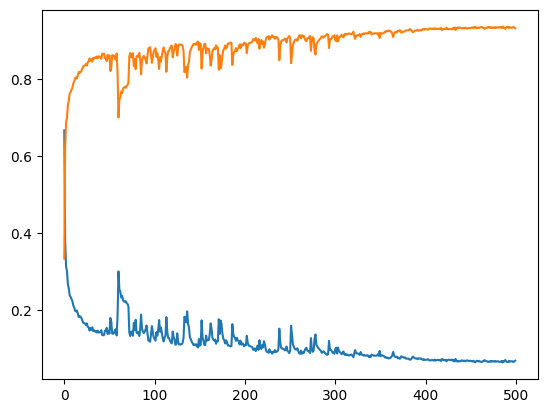

In [16]:
plt.plot(hist.epoch, hist.history['loss'])
plt.plot(hist.epoch, hist.history['f1-score'])

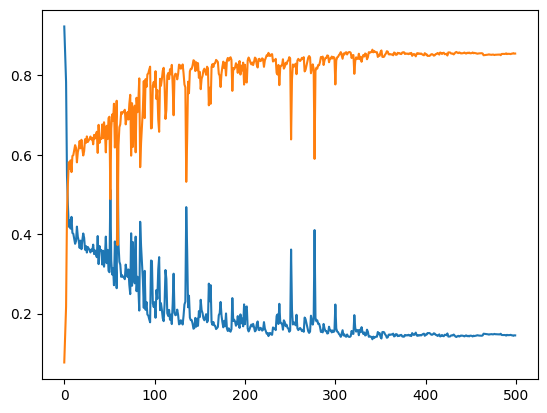

In [17]:
plt.plot(hist.epoch, hist.history['val_loss'])
plt.plot(hist.epoch, hist.history['val_f1-score'])

# Visualize output

In [18]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

2023-06-07 18:29:33.580336: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-06-07 18:29:33.989007: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.




1/1 [==============================] - 27s 27s/step


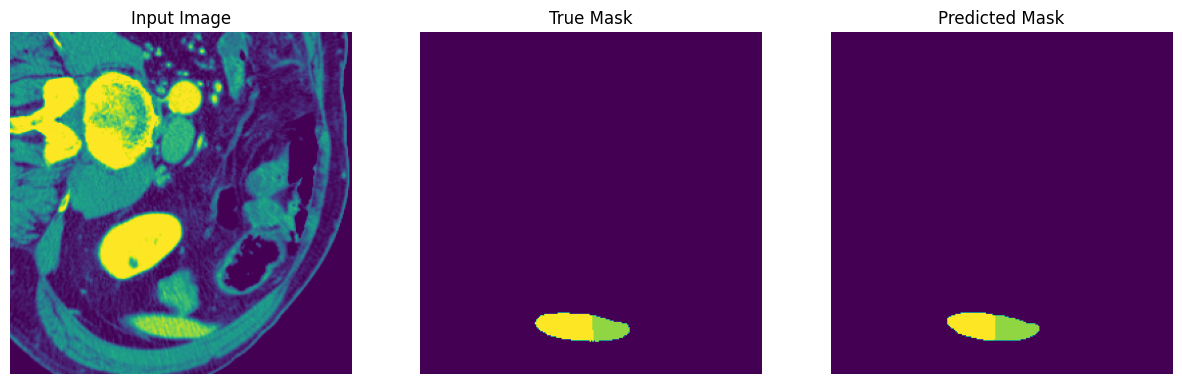



1/1 [==============================] - 1s 566ms/step


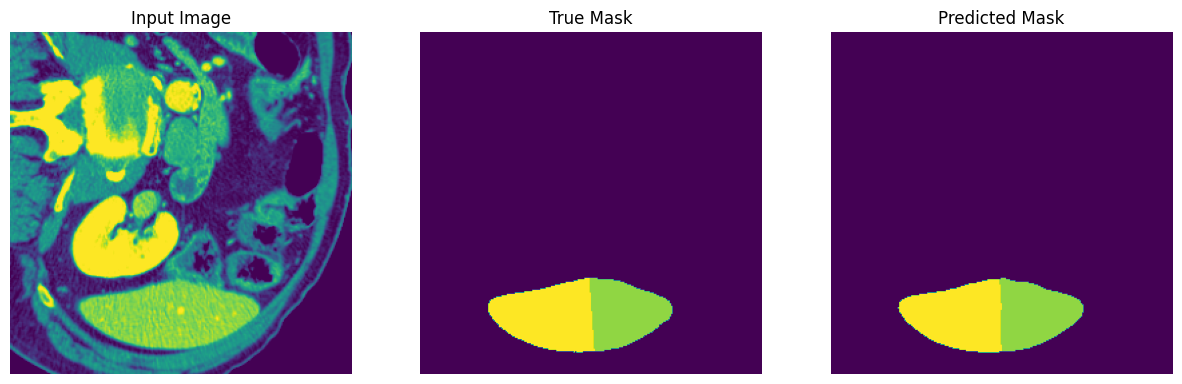



1/1 [==============================] - 1s 536ms/step


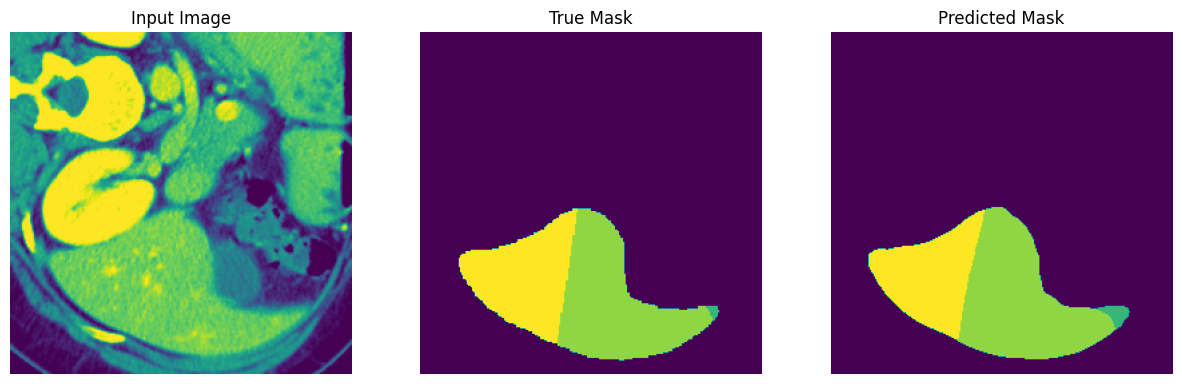



1/1 [==============================] - 2s 2s/step


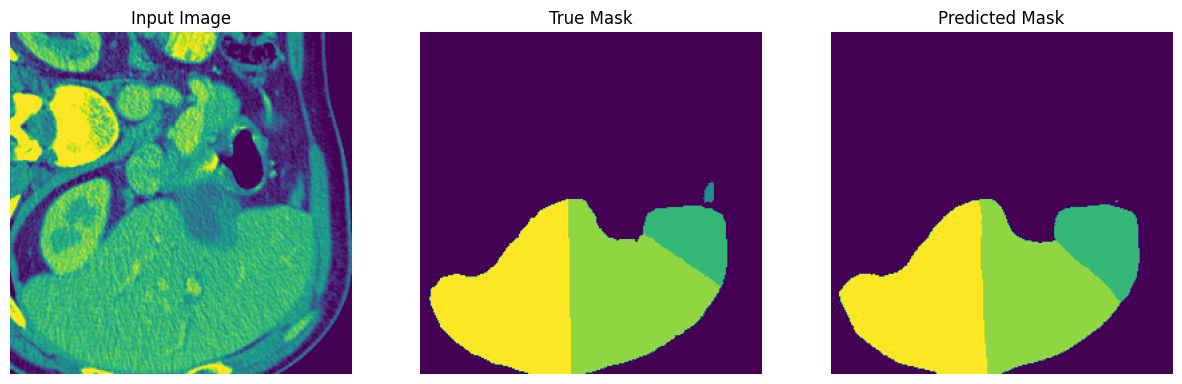



1/1 [==============================] - 1s 633ms/step


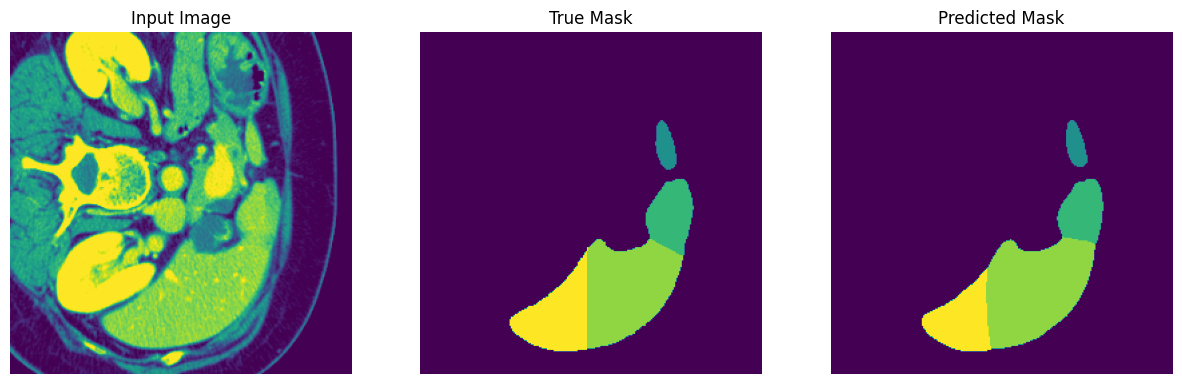



1/1 [==============================] - 1s 645ms/step


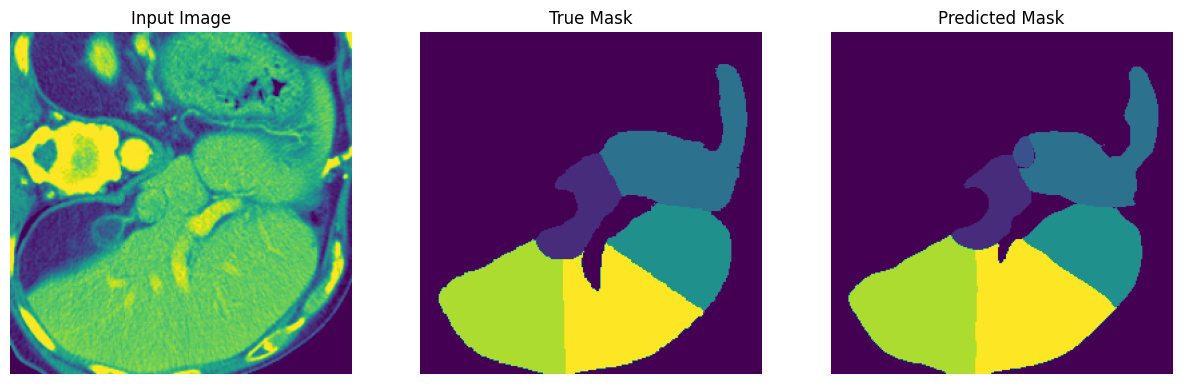



1/1 [==============================] - 1s 604ms/step


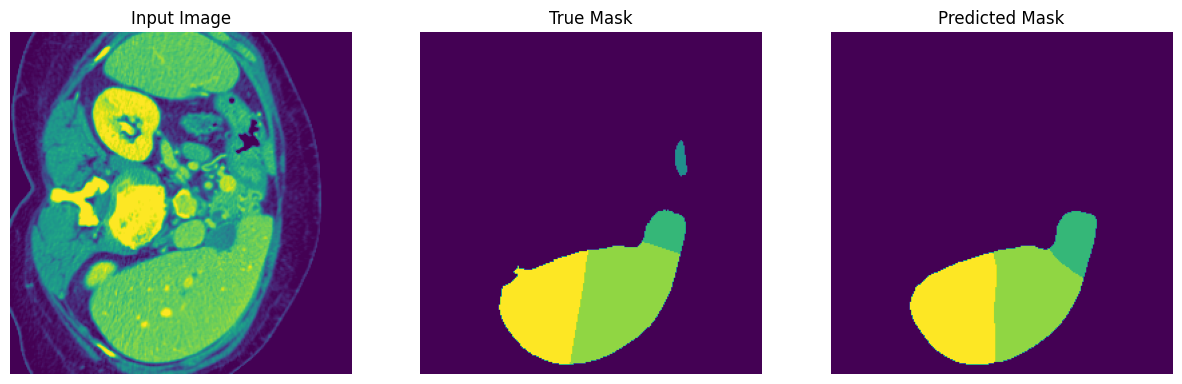



1/1 [==============================] - 1s 593ms/step


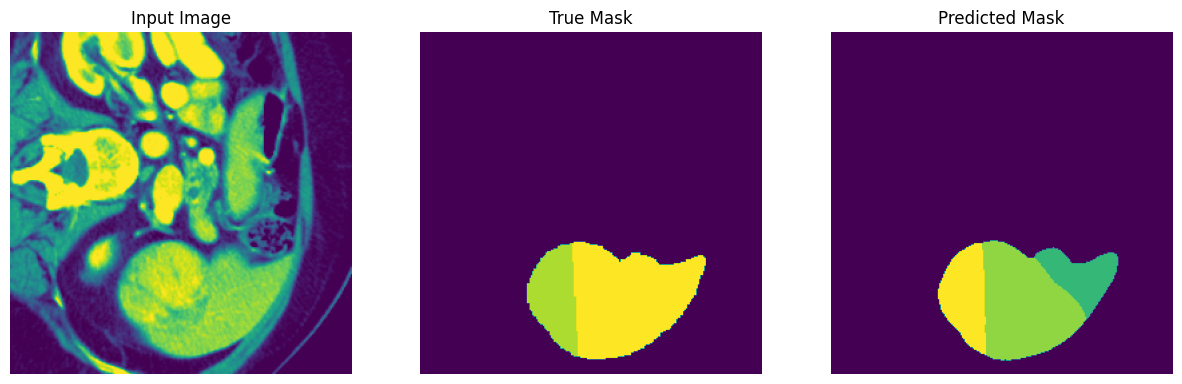



1/1 [==============================] - 1s 611ms/step


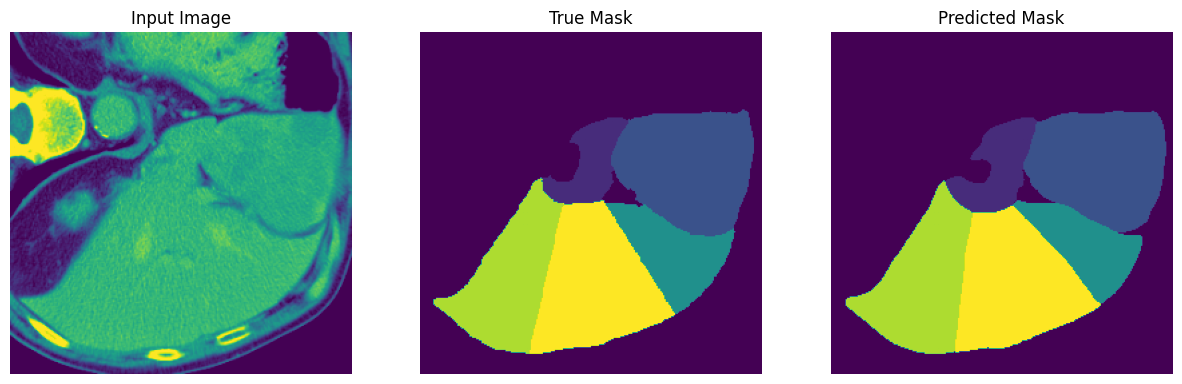



1/1 [==============================] - 1s 623ms/step


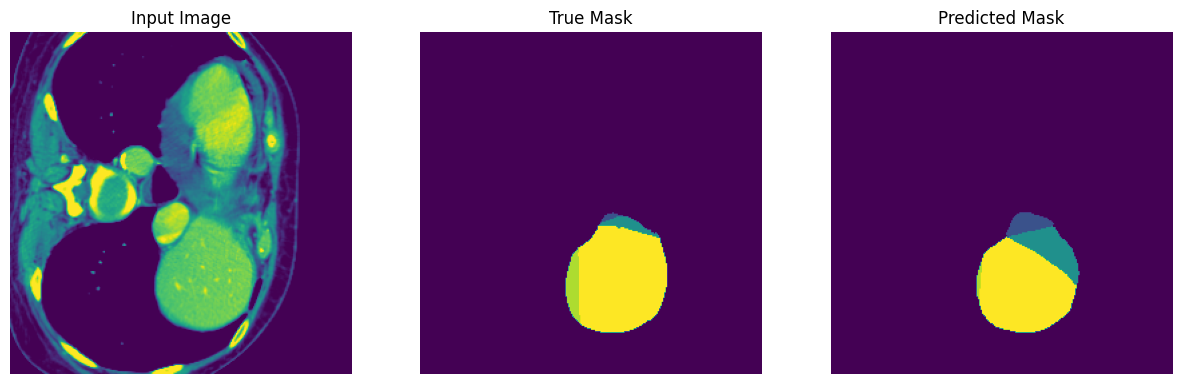



1/1 [==============================] - 1s 546ms/step


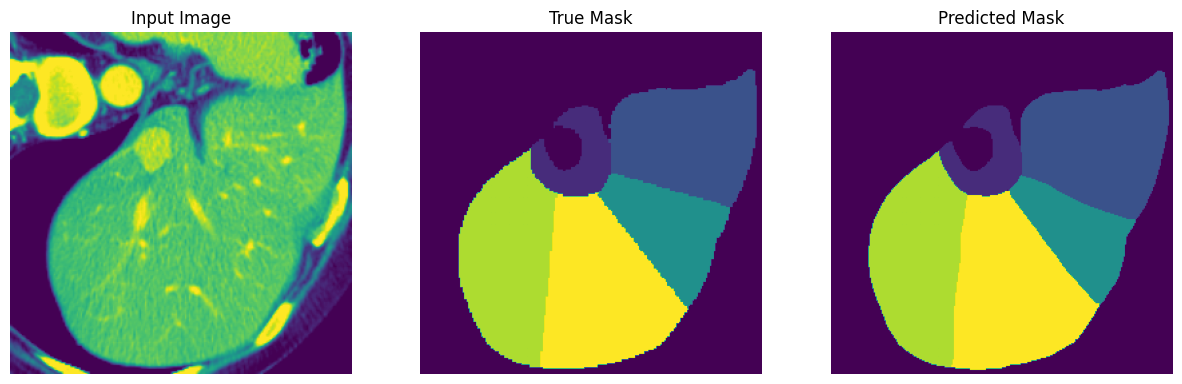



1/1 [==============================] - 1s 545ms/step


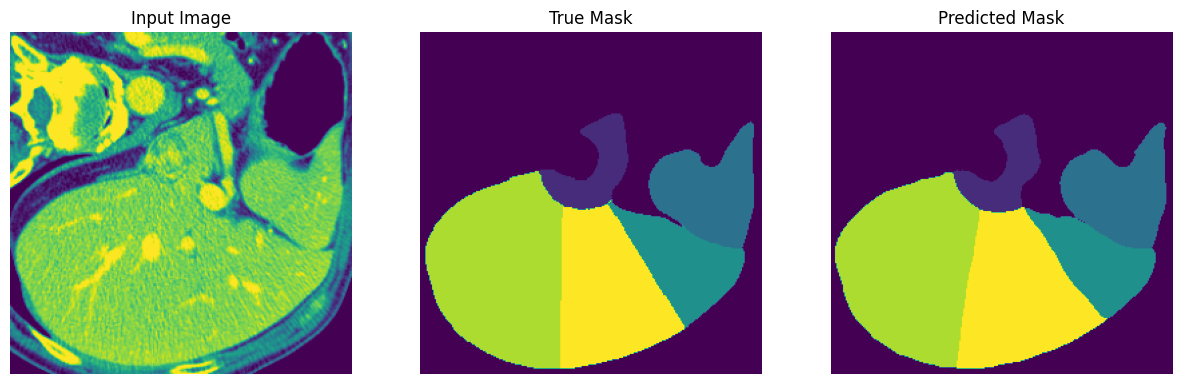

In [19]:
output_id = 0
for img, mask in valid_ds.shuffle(100).take(12):
    img_to_plot = img[0] # only 1st of batch
    mask_to_plot = tf.argmax(mask[0], axis=-1)
    
    predicted_batch = model.predict(img_to_plot[tf.newaxis, ...])
    predicted_mask = tf.argmax(predicted_batch[0], axis=-1) 
    
    display([img_to_plot[..., CONF['channels']//2], mask_to_plot, predicted_mask])
    np.savez(
        file=f'/kaggle/working/out_{output_id}',
        img=img_to_plot[..., CONF['channels']//2], 
        true=mask_to_plot,
        pred=predicted_mask
    )
    output_id += 1

In [20]:
model.evaluate(test_ds, batch_size=CONF['batch_size'])


      1/Unknown - 4s 4s/step - loss: 0.1486 - f1-score: 0.85
      2/Unknown - 4s 74ms/step - loss: 0.1770 - f1-score: 0.82
      3/Unknown - 5s 85ms/step - loss: 0.1844 - f1-score: 0.81
      4/Unknown - 5s 96ms/step - loss: 0.1729 - f1-score: 0.82
      5/Unknown - 5s 145ms/step - loss: 0.1581 - f1-score: 0.841
      6/Unknown - 5s 132ms/step - loss: 0.1508 - f1-score: 0.849
6/6 [==============================] - 6s 281ms/step - loss: 0.1508 - f1-score: 0.8492


[0.15079939365386963, 0.8492006659507751]

In [21]:
!rm -r ./wandb

In [ ]:
tf.keras.models.save_model(model, 'unetmodel.h5')

: 